Total number of shots:256


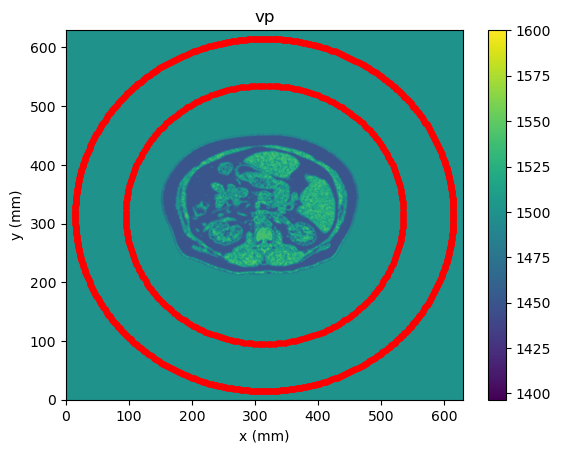

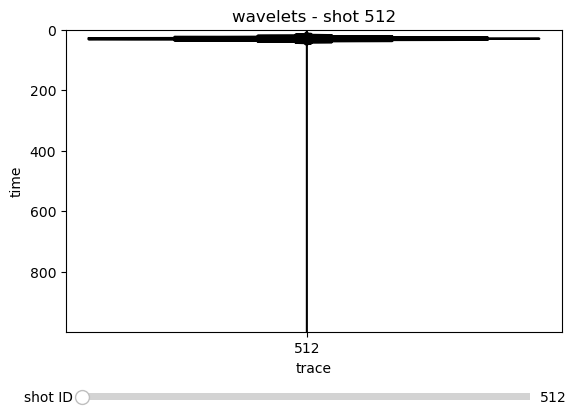

In [3]:
from stride import *
import mosaic
import json
def ellipt_coordinates(num, radius):  # centered at [0,0]

    angles = np.linspace(0, 2 * np.pi, num, endpoint=False)
    geometry = np.zeros((num, 2))
    for index, angle in zip(range(num), angles):

        geometry[index, 0] = radius[0] * np.cos(angle)
        geometry[index, 1] = radius[1] * np.sin(angle)

    return geometry

with open("./configs/0805_gauss.json", "r") as file:
        config = json.load(file)

foldername = os.path.basename("./configs/0805_gauss.json").split('.')[0]
dx = config["dx"]
cfl = config["cfl"]
num_source = config["num_source"]
num_receiver = config["num_receiver"]
num_iters = config["num_iters"]
max_freqs = config["max_freqs"]  # [0.3e6, 0.4e6]
batchsize = config["batchsize"]
map_path = config["map_path"]
f_centre = config["source_centerfreq"]
acq_folder = config["acq_folder"]
acq_name = config["acq_name"]
noise_type = config["noise_type"]

if noise_type == "shift":
    lambda_factor = config["lambda_factor"]
elif noise_type == "gaussian":
    sigma= config["sigma"]
elif noise_type =="scale":
    scale_range= config["scale_range"]

dx_scale = dx / 0.3e-3
cfl_scale = cfl / 0.5
sos = 1500.0

output_folder = os.path.join(os.getcwd(), foldername)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# basics setting
grid_size = int(2100 / dx_scale)
space = Space(
    shape=(grid_size, grid_size), extra=(100, 100), absorbing=(80, 80), spacing=dx
)  # wavelenght : 3e-03 meter
time = Time(
    start=0.0e-7, step=cfl * dx / sos, num=int(10000 / dx_scale / cfl_scale)
)
grid = Grid(space, time)
problem = Problem(
    name="fullbodyring", space=space, time=time, output_folder=output_folder
)

# define transducer geometry
problem.transducers.default()
geometry_type = "elliptical"
problem.geometry.default(geometry_type, num_receiver, radius=[0.3, 0.3])
receivers = problem.geometry.locations

offset = problem.geometry.num_locations
coords_offest = grid_size / 2 * dx
coordinates = ellipt_coordinates(num_source, [0.22, 0.22])
for index in range(coordinates.shape[0]):
    _coordinates = coordinates[index, :]
    if len(_coordinates) != problem.geometry.space.dim:
        _coordinates = np.pad(_coordinates, ((0, 1),))
        _coordinates[-1] = problem.geometry.space.limit[2] / 2

    problem.geometry.add(
        index + offset,
        problem.geometry._transducers.get(0),
        _coordinates + coords_offest,
    )
sources = problem.geometry.locations[offset:]

# ------------------------ Forward problme ------------------------ #
# create shots
t = np.arange(0, time.num * time.step, time.step)
b = 2 / f_centre
delay = 0.03 * time.num * time.step
wave = np.exp(-((t - delay) ** 2) / b**2) * np.cos(
    2 * np.pi * f_centre * (t - delay)
)

for source in sources:
    problem.acquisitions.add(
        Shot(
            source.id,
            sources=[source],
            receivers=receivers,
            geometry=problem.geometry,
            problem=problem,
        )
    )

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wave

print(f"Total number of shots:{len(problem.acquisitions.shots)}")

# define sos ground true map  /
if map_path is not None:
    map = np.load(map_path)
    pad_height = (grid_size - map.shape[0]) // 2
    pad_width = (grid_size - map.shape[1]) // 2

    data = np.pad(
        map,
        pad_width=((pad_height, pad_height), (pad_width, pad_width)),
        constant_values=1500,
    )
else:
    data = np.full((grid_size, grid_size), 1500, dtype=int)
    s = 0.08 / dx
    R = s / np.sqrt(3)
    angles = np.deg2rad([90, 210, 330])  # Convert degrees to radians
    centers = [(R * np.cos(theta), R * np.sin(theta)) for theta in angles]
    radii = [0.02 / dx, 0.03 / dx, 0.04 / dx]
    sos_vals = [1450, 1475, 1550]
    y, x = np.ogrid[:grid_size, :grid_size]
    origin = grid_size / 2

    for center, radius, sos in zip(centers, radii, sos_vals):
        mask = (x - center[0] - origin) ** 2 + (
            y - center[1] - origin
        ) ** 2 <= radius**2
        data[mask] = sos

vp_true = ScalarField(name="vp", grid=problem.grid, data=data)
problem.medium.add(vp_true)
problem.plot()

In [4]:
try:
    problem.acquisitions.load(
        path=acq_folder, project_name=acq_name, version=0
    )
    print("Acquisitions loaded")
except OSError:
    print("Fail to load Acquisitions")

Acquisitions loaded


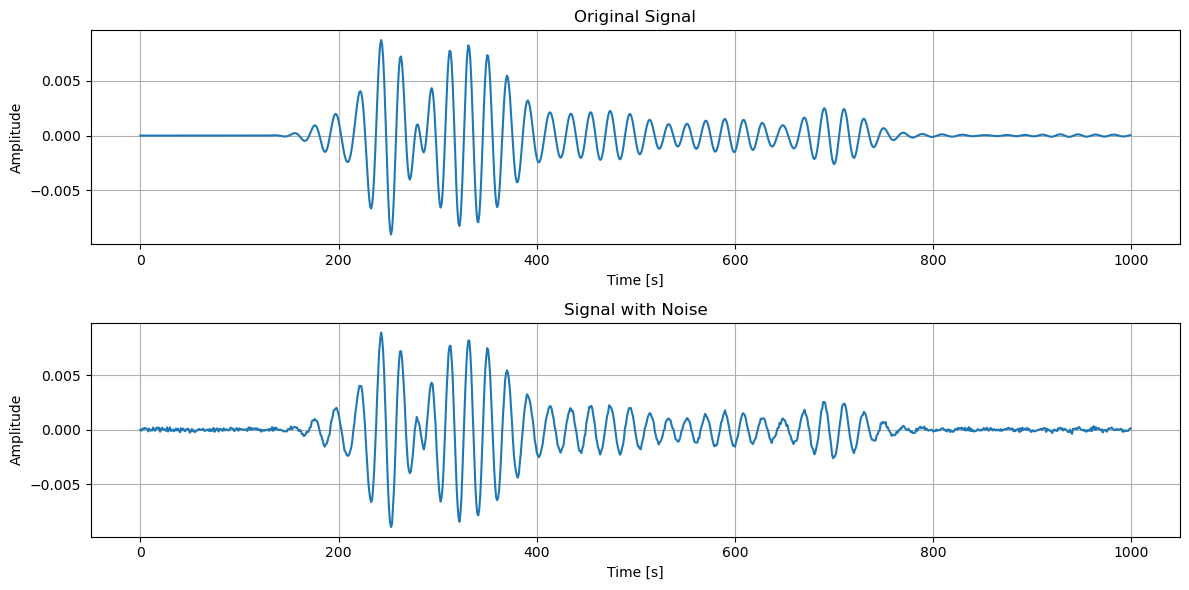

In [8]:
import numpy as np
import matplotlib.pyplot as plt
shot0 = problem.acquisitions.get(512)
signal = shot.observed.data[200]
noise = np.random.normal(0, sigma, signal.shape)

noisy_signal = signal + noise

# Step 3: Visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(signal[1500:2500], label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(noisy_signal[1500:2500], label='Noisy Signal')
plt.title('Signal with Noise')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
SP = np.sqrt(np.mean(signal[1500:2500] ** 2))
NP = np.sqrt(np.mean(noise[1500:2500] ** 2))

SNR = 10*np.log10(SP/NP)
print(SP, NP, SNR)

0.0020986088 9.910036303461415e-05 13.25856236338657


In [ ]:
shot_ids = problem.acquisitions.shot_ids
shots = [problem.acquisitions.get(id) for id in shot_ids]
for shot in shots:
    for i in range(num_receiver):
        noise = np.random.normal(0, sigma, shot.observed.data[i].shape)
        shot.observed.data[i] = shot.observed.data[i] + noise